# 손 joint

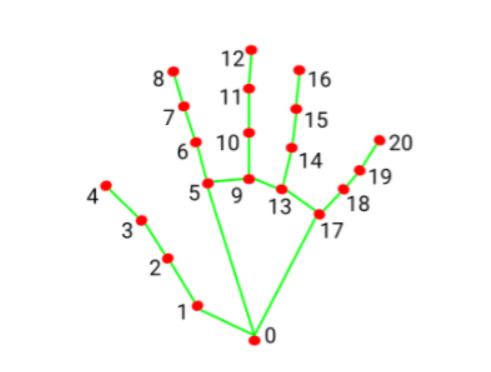

# 한 손 한글 제스처

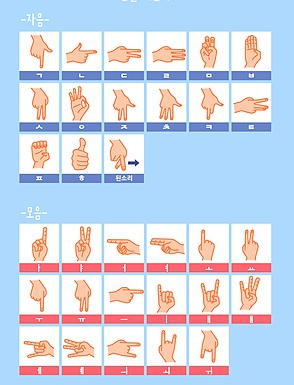

# 생성된 데이터셋의 예측 결과 값 확인

In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

file = np.genfromtxt('./data/gesture.csv', delimiter=',')
x_data = file[:,:-1].astype(np.float32)  ## X 데이터
y_data = file[:, -1].astype(np.float32)  ## Y 데이터 (라벨값)

train, test, train_labels, test_labels = train_test_split(x_data, y_data, test_size=0.2)
test_labels = test_labels.reshape((test_labels.size, 1))
train_labels = train_labels.reshape((train_labels.size, 1))

knn = cv2.ml.KNearest_create()                      ## K-NN 알고리즘 객체 생성
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)   ## train, 행 단위 샘플

## k값에 따른 예측값 확인
for k in range(1, 11):
    
    ret, result, neighbors, distance = knn.findNearest(test, k=k)
        ## data : 입력 데이터
        ## k : 사용할 최근접 이웃 갯수 K (1 이상)
        ## result : 예측 결과 (입력 데이터와 같은 크기의 배열)
        ## neighbors : K 범위 내에 있는 이웃 데이터
        ## distance : 입력 데이터와 이웃 데이터간 거리

        
    # 정확도 계산 및 출력
    correct = np.sum(result == test_labels)
    accuracy = correct / result.size * 100.0
    print("K:{} / Accuracy : {:.2f} ({}/{})\n".format(k, accuracy, correct, result.size))

K:1 / Accuracy : 97.19 (277/285)

K:2 / Accuracy : 95.44 (272/285)

K:3 / Accuracy : 95.09 (271/285)

K:4 / Accuracy : 93.68 (267/285)

K:5 / Accuracy : 93.33 (266/285)

K:6 / Accuracy : 92.63 (264/285)

K:7 / Accuracy : 92.28 (263/285)

K:8 / Accuracy : 91.93 (262/285)

K:9 / Accuracy : 91.93 (262/285)

K:10 / Accuracy : 91.93 (262/285)



# 실행

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import time
from PIL import ImageFont, ImageDraw, Image            ## 설치 참고 ( !pip install pillow )
from hangul_utils import split_syllables, join_jamos   ## 설치 참고 ( !pip install hangul-utils )


## 자음, 모음 된 글자를 문장으로 변환
def char_to_sentence(jamo):
    ## 고유한 문자들을 추린 다음, 문자-숫자 간 1:1 대응하는 딕셔너리를 만듬
    chars = list(set(jamo))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }
    
    ## 딕셔너리를 이용하여 자음 모음을 숫자로 변환
    jamo_numbers = [char_to_ix[x] for x in jamo]

    ## ix_to_char 딕셔너리를 이용하여 다시 숫자를 문자로 변환하고 
    ## join_jamos로 분리한 자음 모음을 합쳐 문장으로 만듬
    restored_jamo = ''.join([ix_to_char[x] for x in jamo_numbers])
    sentence = join_jamos(restored_jamo)
    
    return sentence

## opencv 화면에 한글을 출력하기 위해 폰트 설정
font = ImageFont.truetype("./fonts/SCDream6.otf", 25)

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

## 한글 자음 모음
gesture_ko = {0:'ㄱ', 1:'ㄴ', 2:'ㄷ', 3:'ㄹ', 4:'ㅁ', 5:'ㅂ', 6:'ㅅ', 
               7:'ㅇ', 8:'ㅈ', 9:'ㅊ', 10:'ㅋ', 11:'ㅌ', 12:'ㅍ', 13:'ㅎ',
               14:'ㅏ', 15:'ㅑ', 16:'ㅓ', 17:'ㅕ', 18:'ㅗ', 19:'ㅛ',
               20:'ㅜ', 21:'ㅠ', 22:'ㅡ', 23:'ㅣ', 24:'ㅐ', 25:'ㅒ',
               26:'ㅔ', 27:'ㅖ', 28:'ㅢ', 29:'ㅚ', 30:'ㅟ',
               31:'enter', 32:'back', 33:'space'}

## 한글 발음대로 작성한 영어
gesture_en = {0:'g', 1:'n', 2:'d', 3:'r', 4:'m', 5:'b', 6:'s', 
               7:'ng', 8:'j', 9:'ch', 10:'k', 11:'t', 12:'p', 13:'h',
               14:'a', 15:'ya', 16:'eo', 17:'yeo', 18:'o', 19:'yo',
               20:'u', 21:'yu', 22:'eu', 23:'i', 24:'ae', 25:'yae',
               26:'e', 27:'ye', 28:'ui', 29:'oe', 30:'wi',
               31:'enter', 32:'back', 33:'space'}

## 최대 1개의 손만 인식
max_num_hands = 1   
hands = mp_hands.Hands(max_num_hands = max_num_hands,
                       min_detection_confidence = 0.5,
                       min_tracking_confidence = 0.5)

file = np.genfromtxt('./data/gesture.csv', delimiter=',')
angle = file[:,:-1].astype(np.float32)
label = file[:, -1].astype(np.float32)

knn = cv2.ml.KNearest_create()              ## K-NN 알고리즘 객체 생성
knn.train(angle, cv2.ml.ROW_SAMPLE, label)  ## train, 행 단위 샘플

cap = cv2.VideoCapture(0)

prev_index = 0
char = ''        # 한글 자음, 모음
sentence = ''    # 자음 모음을 모아 만든 문장
startTime = time.time()

while cap.isOpened():
    ret, frame = cap.read()

    ## opencv는 bgr 형태이기 때문에 영상 컬러를 조정 해야 함
    video = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # 웹캠에서 bgr에서 rgb로 변경
    video = cv2.flip(video, 1)

    video.flags.writeable = False                     # false로 쓰기 불가능한 상태로 설정

    # Make detection
    result = hands.process(video)                     # 감지

    video.flags.writeable = True                      # True로 쓰기 가능한 상태로 설정
    video = cv2.cvtColor(video, cv2.COLOR_RGB2BGR)    # rgb에서 bgr로 변경하여 opencv로 작동하도록 설정


    if result.multi_hand_landmarks is not None:      # 손 인식 했을 경우
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 3))                 # 21개의 마디 부분 좌표 (x, y, z)를 joint에 저장
            for j,lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            # 벡터 계산
            v1 = joint[[0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19],:]
            v2 = joint[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],:]
            v = v2 - v1

            # 벡터 길이 계산 (Normalize v)
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # arcos을 이용하여 15개의 angle 구하기
            angle = np.arccos(np.einsum('nt,nt->n',
                                        v[[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18],:],
                                        v[[1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19],:]))

            angle = np.degrees(angle)  # radian 값을 degree로 변경

            data = np.array([angle], dtype=np.float32)
            
            ret, results, neighborResponses, distance = knn.findNearest(data, 1)  
            ## 훈련용과 테스트용 데이터셋으로 예측했을 경우 k=1 일때 정확도가 가장 높게 나옴

            index = int(results[0][0])

            if index in gesture_ko.keys():
                if index != prev_index:
                    startTime = time.time()
                    prev_index = index
                else:
                    if time.time() - startTime > 1.5:
                        if index == 31:    ## 문장 출력
                            char_to_sentence(char)
                            
                        elif index == 32:  ## 문장 지우기
                            if char == '':
                                pass
                            else:
                                char = ''
                                
                        elif index == 33:  ## 띄어쓰기
                            char += ' '
                            
                        else:              ## 1.5초 이상 같은 문자가 계속 인식될 경우 화면에 출력
                            char += gesture_ko[index]
                        startTime = time.time()

                ## opencv에서는 한글 출력 시 PIL을 사용해야 하기 때문에 Mediapipe와 충돌이 생겨 오류 발생
                ## 예측 문자는 영어로 출력
                cv2.putText(video, gesture_en[index].upper(), 
                               (int(res.landmark[0].x * video.shape[1] - 20),
                                int(res.landmark[0].y * video.shape[0] + 50)),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3, cv2.LINE_AA)

            mp_drawing.draw_landmarks(video, res, mp_hands.HAND_CONNECTIONS)

    ## 최종 예측 문자는 한글로 출력
    ## opencv에서 한글 출력 (PIL)
    video = Image.fromarray(video)
    draw = ImageDraw.Draw(video)

    draw.text(xy=(10, 15), text = char, font=font, fill=(255, 255, 255))
    draw.text(xy=(10, 50), text = char_to_sentence(char), font=font, fill=(255, 255, 255))
    video = np.array(video)

    cv2.imshow("Hand Gesture", video)
    if cv2.waitKey(10) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()